## Import dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np
from scipy.fftpack import dct
import numpy as np
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from transformers import DistilBertTokenizer, TFDistilBertModel

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataloader

In [2]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/train_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/train_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = '/kaggle/input/ham10000-data/HAM10000_DATA/test_dir',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=False,
                                                   batch_size = 64)

Found 36411 images belonging to 7 classes.
Found 15601 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


In [3]:
print(train_dataset.class_indices)
print(validation_dataset.class_indices)
print(test_dataset.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


## Metrics

In [4]:
def f1_score(y_true, y_pred):
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

## Model

#### CBAM

In [5]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = K.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = K.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = K.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = K.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = K.layers.Activation("sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = K.layers.Concatenate()([x1, x2])
    ## Conv layer
    feats = K.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

#### Deep Learner

In [6]:
input_layer = K.Input(shape=(160,160,3))
deep_learner = K.applications.MobileNetV2(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in deep_learner.layers:
    layer.trainable = True
for i, layer in enumerate(deep_learner.layers):
    print(i, layer.name, "-", layer.trainable)

9406464/9406464 [==============================] - 0s 0us/step
0 input_1 - True
1 Conv1 - True
2 bn_Conv1 - True
3 Conv1_relu - True
4 expanded_conv_depthwise - True
5 expanded_conv_depthwise_BN - True
6 expanded_conv_depthwise_relu - True
7 expanded_conv_project - True
8 expanded_conv_project_BN - True
9 block_1_expand - True
10 block_1_expand_BN - True
11 block_1_expand_relu - True
12 block_1_pad - True
13 block_1_depthwise - True
14 block_1_depthwise_BN - True
15 block_1_depthwise_relu - True
16 block_1_project - True
17 block_1_project_BN - True
18 block_2_expand - True
19 block_2_expand_BN - True
20 block_2_expand_relu - True
21 block_2_depthwise - True
22 block_2_depthwise_BN - True
23 block_2_depthwise_relu - True
24 block_2_project - True
25 block_2_project_BN - True
26 block_2_add - True
27 block_3_expand - True
28 block_3_expand_BN - True
29 block_3_expand_relu - True
30 block_3_pad - True
31 block_3_depthwise - True
32 block_3_depthwise_BN - True
33 block_3_depthwise_relu - 

#### Model

In [7]:
input_img = K.layers.Input(shape=(160,160,3)) 
feat_img = deep_learner(input_img)
flat = K.layers.GlobalAveragePooling2D()(feat_img)
output = K.layers.Dense(7, activation='softmax')(flat)

model = K.Model(inputs=input_img, outputs=output)
optimizer = K.optimizers.Adam(lr=0.01)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 2,266,951
Trainable params: 2,232,839
Non-trainable params: 34,112
_________________________________________________________________


## Training

In [8]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='MobileNetV2.h5',
    monitor='val_f1_score',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 50,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/50
569/569 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.7764 - precision: 0.8405 - recall: 0.7135 - auc: 0.9683 - f1_score: 0.7667
Epoch 1: val_f1_score improved from -inf to 0.21270, saving model to MobileNetV2.h5
569/569 [==============================] - 704s 1s/step - loss: 0.6091 - accuracy: 0.7764 - precision: 0.8405 - recall: 0.7135 - auc: 0.9683 - f1_score: 0.7667 - val_loss: 14.0770 - val_accuracy: 0.2127 - val_precision: 0.2128 - val_recall: 0.2127 - val_auc: 0.5371 - val_f1_score: 0.2127
Epoch 2/50
569/569 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.8717 - precision: 0.8957 - recall: 0.8482 - auc: 0.9882 - f1_score: 0.8710
Epoch 2: val_f1_score improved from 0.21270 to 0.28535, saving model to MobileNetV2.h5
569/569 [==============================] - 201s 352ms/step - loss: 0.3530 - accuracy: 0.8717 - precision: 0.8957 - recall: 0.8482 - auc: 0.9882 - f1_score: 0.8710 - val_loss: 13.5762 - val_accuracy: 0.2852 - 

#### Training plots

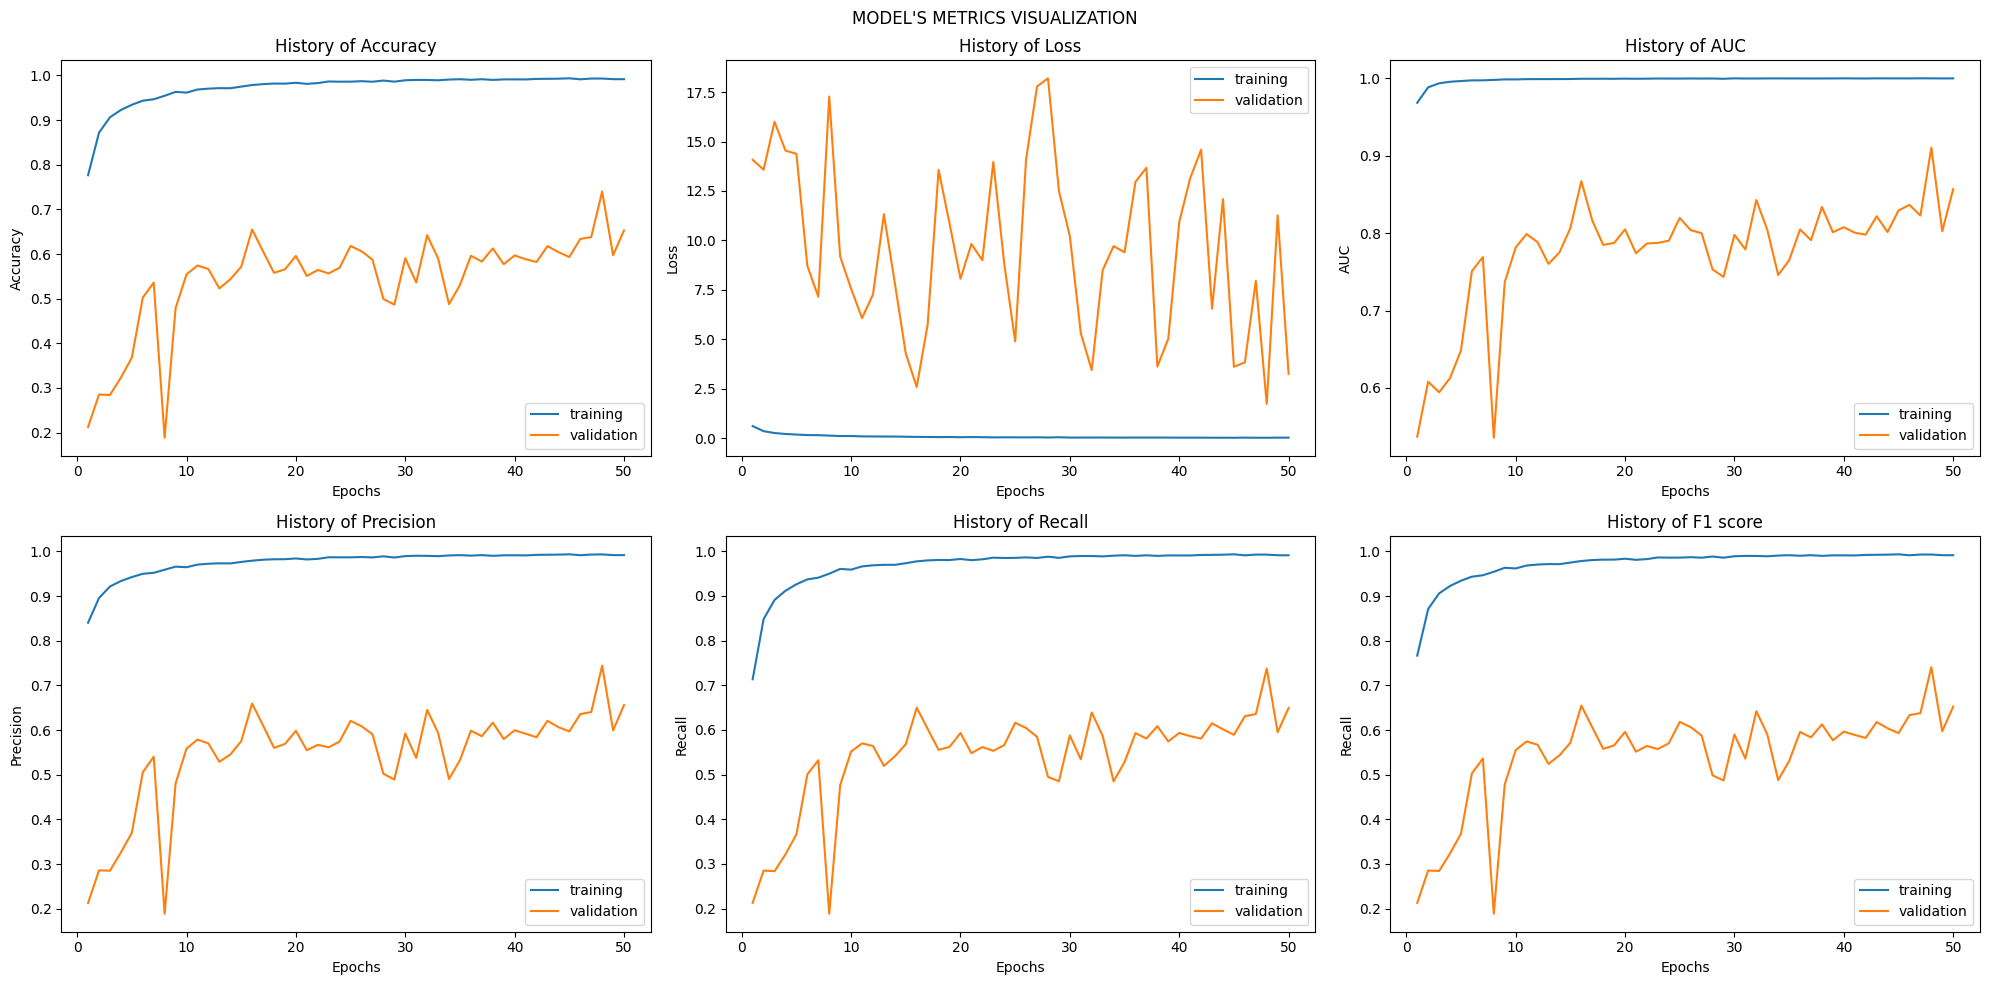

In [9]:
import matplotlib.pyplot as plt

def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, recall, val_recall, f1_score, val_f1_score):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    axes[0, 0].plot(range(1, len(acc) + 1), acc)
    axes[0, 0].plot(range(1, len(val_acc) + 1), val_acc)
    axes[0, 0].set_title('History of Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend(['training', 'validation'])

    axes[0, 1].plot(range(1, len(loss) + 1), loss)
    axes[0, 1].plot(range(1, len(val_loss) + 1), val_loss)
    axes[0, 1].set_title('History of Loss')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend(['training', 'validation'])

    axes[0, 2].plot(range(1, len(auc) + 1), auc)
    axes[0, 2].plot(range(1, len(val_auc) + 1), val_auc)
    axes[0, 2].set_title('History of AUC')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('AUC')
    axes[0, 2].legend(['training', 'validation'])

    axes[1, 0].plot(range(1, len(precision) + 1), precision)
    axes[1, 0].plot(range(1, len(val_precision) + 1), val_precision)
    axes[1, 0].set_title('History of Precision')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend(['training', 'validation'])

    axes[1, 1].plot(range(1, len(recall) + 1), recall)
    axes[1, 1].plot(range(1, len(val_recall) + 1), val_recall)
    axes[1, 1].set_title('History of Recall')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend(['training', 'validation'])

    axes[1, 2].plot(range(1, len(f1_score) + 1), f1_score)
    axes[1, 2].plot(range(1, len(val_f1_score) + 1), val_f1_score)
    axes[1, 2].set_title('History of F1 score')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Recall')  # Corrected from 'Recall' to 'F1 score'
    axes[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

# Call the function with your history data
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['recall'], history.history['val_recall'],
               history.history['f1_score'], history.history['val_f1_score'])

## Testing

In [10]:
model = K.models.load_model("/kaggle/working/MobileNetV2.h5", custom_objects={"f1_score": f1_score})

# Evaluate the model
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
print("Accuracy", accuracy)
print("Loss", loss)
print("Precision", precision)
print("Recall", recall)
print("AUC", auc)
print("F1-score", f1_score)

18/18 [==============================] - 8s 456ms/step - loss: 1.1984 - accuracy: 0.8286 - precision: 0.8324 - recall: 0.8241 - auc: 0.9457 - f1_score: 0.8313
Accuracy 0.8286491632461548
Loss 1.1984068155288696
Precision 0.8324176073074341
Recall 0.824116051197052
AUC 0.9456735849380493
F1-score 0.831294059753418


/tmp/ipykernel_28/493592024.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


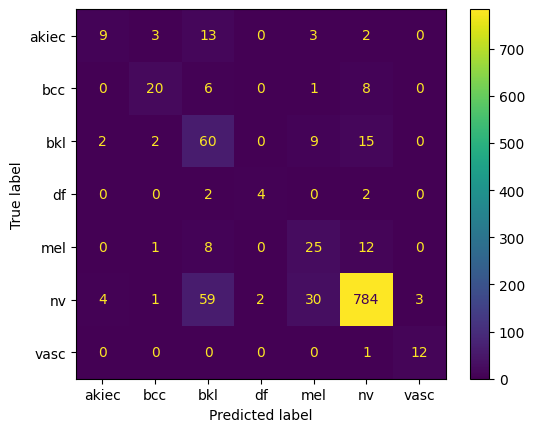

Classification Report
              precision    recall  f1-score   support

       akiec       0.60      0.30      0.40        30
         bcc       0.74      0.57      0.65        35
         bkl       0.41      0.68      0.51        88
          df       0.67      0.50      0.57         8
         mel       0.37      0.54      0.44        46
          nv       0.95      0.89      0.92       883
        vasc       0.80      0.92      0.86        13

    accuracy                           0.83      1103
   macro avg       0.65      0.63      0.62      1103
weighted avg       0.86      0.83      0.84      1103



In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))